In [ ]:
# Libraries
import googlemaps
import uuid
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
from langchain.agents import create_agent, AgentState
from langchain.tools import tool
from langgraph.checkpoint.memory import InMemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import List, Literal, Optional, Dict
from tavily import TavilyClient
from pydantic import BaseModel, Field
from datetime import datetime
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage

from typing import Any
from langchain.agents.middleware import before_model, ModelRequest
from langchain.messages import SystemMessage

from agents.flight_agent import FlightSpecialistAgent, One_way_flight_search
from agents.destination_agent_service import DestinationInfoAgent, attraction_finding_tool, hotel_finding_tool, restaurant_finding_tool
from agents.Info_gather_chatbot import InformationGatherChatbot
from agents.formats.trip_requirement import ConversationFormat, TripRequirement
from agents.tools.distance_measurement_tool import distance_measurement_tool
from agents.web_agent import web_search_tool
from src.agents.final_trip_planner_agent import FinalTripPlanner


In [ ]:
from serpapi import GoogleSearch
params = {
    "engine": "tripadvisor",
    "q": "Beijing",
    "ssrc": "A",
    "api_key": ""
    }
search = GoogleSearch(params)

In [ ]:
# API and environments
os.environ["GPLACES_API_KEY"] = ""
os.environ["GOOGLE_API_KEY"] = ""
os.environ["TAVILY_API_KEY"] = ""
os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"
tavily_api = os.environ["TAVILY_API_KEY"]
api =os.environ["GPLACES_API_KEY"]
gmaps = googlemaps.Client(api)
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0, max_retries = 3, timeout=90, api_key = "")
parent_model = ChatGoogleGenerativeAI(model="gemini-3-pro-preview", temperature=0, max_retries = 3, timeout=160)
tavily_client = TavilyClient(tavily_api)
checkpointer = InMemorySaver()
thread_id = "user_1"

In [3]:
class CustomState(AgentState):
    Departure: str = None
    Destination: List['str'] = Field(None, description = "The place you want to go")
    StartDate: str = Field(None, description = "The date to start the trip: YYYY-MM-DD")
    Duration: str = Field(None, description = "The total number of days planned for trip")
    Budget: str = Field(None, description = "The overall budget of the trip")
    Interest: List[str] = Field(None, description = "The personality of person, Reccomendations are givenm based on the Interest of person")
    AllDetails: bool = Field(False, description = "True, if all details are completed, otherwise False")
    ExtraDetail: List[str] = Field(None, description = "Some Extra Information to provide")
    Response: str = Field(None, description = "The response of Model")
    move_to_info_chatbot: bool = Field(False, description = "")
    previous_plan: str = None
    TravelMode: str = Field("Travel_Plan", description = "When you want plan from scratch, it is Travel_Plan and for Revision_Plan")
    flight_info: str = None
    hotel_info: str = None

In [5]:
c = InformationGatherChatbot(model, ConversationFormat)
flight_agent = FlightSpecialistAgent(model, One_way_flight_search)
trip_advisor_agent = DestinationInfoAgent(model, [attraction_finding_tool, hotel_finding_tool, restaurant_finding_tool])

In [6]:
main_agent_system_prompt = """
You are the **Senior Travel Architect**. You are NOT a creative writer; you are a logistics engine. 
Your job is to compile a strictly factual travel itinerary based on the **Provided Data** in the context.

### INPUT DATA SOURCES
You will receive data in the context labeled as:
1. `flight_info` (Fixed. Do not change.)
2. `hotel_info` (Fixed. Do not change.)
3. `user_preferences` (Budget, Interest, Duration)

### MANDATORY TOOL USAGE
You possess the `distance_measurement_tool`. You MUST use it for the following:
1. Calculate distance from **Hotel** to **Airport**.
2. Calculate distance from **Hotel** to **Every Major Attraction** you suggest.
*If the tool fails, state "Distance unavailable" - DO NOT GUESS.*

### EXECUTION STEPS
1. **Sanity Check**: Verify `flight_info` and `hotel_info` are present. If missing, output: "CRITICAL ERROR: Missing logistics data."
2. **Enrichment**: Use `web_search_tool` ONLY to find:
   - Operating hours of attractions.
   - Specific entry requirements (Visa) if not in context.
   - Local safety warnings for the specific travel dates.
3. **Synthesis**: Build the itinerary.

### OUTPUT FORMAT (Markdown)
**TITLE: [Duration] Day Trip to [Destination]**

#### 1. Logistics Snapshot
* **Flight:** [Airline] | [Price] | [Duration] (Source: Provided Data)
* **Accommodation:** [Hotel Name] | [Address] (Source: Provided Data)
* **Total Est. Budget:** [Sum of Flight + Hotel + $50/day/person for food]

#### 2. Risk & Requirements
* **Visa:** [Details]
* **Safety:** [Real-time safety info from Web Search]

#### 3. Itinerary
**Day 1**
* **Morning:** [Activity]
* **Logistics:** [Distance/Time from Hotel using Tool]
...

### 🛡️ SAFETY & COMPLIANCE (CRITICAL)
* **NO MATH**: Do not try to convert currencies. Quote prices as given.
* **NO HALLUCINATION**: If the provided flight data says "No price," write "Price TBD." Do not invent a price like "$500".
* **CONSISTENCY**: If the user budget is $1000 and the flight+hotel is $1200, explicitly highlight this budget overflow in the "Logistics" section.
"""

update_agent_system_prompt = """
You are the **Travel Plan Optimizer**. Your goal is to apply a specific **Patch** to an existing itinerary.

### CONTEXT AWARENESS
You have access to:
1. **Original Plan** (The text previously generated).
2. **User Feedback** (The specific change requested).
3. **New Data** (Fresh Flight or Hotel info fetched by previous agents, if applicable).

### REVISION LOGIC (The "Diff" Process)
Compare **New Data** vs **Original Plan**:
* **IF Hotel Changed:**
    1. Replace Hotel Name/Address in "Logistics".
    2. **MANDATORY:** Call `distance_measurement_tool` for Hotel -> Attractions. (Old distances are now wrong).
    3. Keep the daily activities the same unless they are now too far away.
* **IF Flight Changed:**
    1. Update "Logistics" section.
    2. Update Day 1 and Final Day timing based on arrival/departure times.
* **IF User just wants formatting/style changes:**
    1. Do NOT call any tools. Just re-write the text.

### OUTPUT FORMAT
* Return the **FULL** updated itinerary in the exact same Markdown format as the Original Plan.
* Do not add "Here is the updated plan" chatter. Just start with "**TITLE:...**"

### 🛡️ GUARDRAILS
* **Preservation:** If the user complained about the "Hotel", DO NOT change the "Flights". Touch only what is broken.
* **Silence:** Do not explain *why* you made changes (e.g., "I removed the museum because..."). Just present the corrected plan.
"""

@before_model
def switch_system_prompt(state: Any, runtime: Any) -> dict[str, Any] | None:
    """
    Switch the prompt based on the usecase
    """
    # Example condition: check a key in agent state
    if state.get("task_mode") == "Travel_Plan":
        new_prompt = main_agent_system_prompt
    else:
        new_prompt = update_agent_system_prompt
    
    # Use a SystemMessage to override the prompt for this model request
    return {"system_message": SystemMessage(content=new_prompt)}


travel_partner = create_agent(model= model, tools = [web_search_tool, distance_measurement_tool],system_prompt = main_agent_system_prompt, middleware = [switch_system_prompt])


In [7]:
def gather_info_node(state: CustomState):
    print("--- Gathering Info Node ---")
    
    # 1. Get User Input
    messages = state.get("messages", [])
    if not messages:
        return {"messages": [AIMessage(content="Error: No messages found.")]}
    
    last_message = messages[-1]
    user_input = last_message.content if hasattr(last_message, 'content') else last_message['content']

    # 2. Identify what is CURRENTLY missing (based on OLD state)
    required_fields = ["Departure", "Destination", "StartDate", "Duration", "Budget", "Interest", "ExtraDetail"]
    current_missing = []
    
    for field in required_fields:
        val = state.get(field)
        # Check for None, "None", "Null", or Empty List
        if val is None or val in ["None", "Null", "null"] or (isinstance(val, list) and len(val) == 0):
            current_missing.append(field)
            
    print(f"Missing before this turn: {current_missing}")

    # 3. Call Chatbot
    extracted_data = c.ask(user_input, missing_list=current_missing)
    
    # 4. MERGE LOGIC (Updated for Lists)
    final_updates = {}
    
    for field in required_fields:
        new_val = extracted_data.get(field) # What user just said
        old_val = state.get(field)          # What we already knew
        
        # --- FIX START ---
        # Determine if the NEW value is actually "empty" or "useless"
        is_new_empty = (
            new_val is None or 
            new_val in ["None", "Null", "null"] or 
            (isinstance(new_val, list) and len(new_val) == 0) # <--- Critical: Catch empty lists
        )
        
        if not is_new_empty:
            # If new value is VALID (e.g., ["Paris"], "2025-01-01"), update it
            final_updates[field] = new_val
        else:
            # If new value is EMPTY (e.g., [], None), keep the OLD value
            final_updates[field] = old_val
        # --- FIX END ---
            
    # 5. Re-Check Completion
    is_complete = True
    for field in required_fields:
        val = final_updates.get(field)
        # Same strict check for completion
        if val is None or val in ["None", "Null", "null"] or (isinstance(val, list) and len(val) == 0):
            is_complete = False
            break

    # 6. Return the updates
    return {
        "Departure": final_updates["Departure"],
        "Destination": final_updates["Destination"],
        "StartDate": final_updates["StartDate"],
        "Duration": final_updates["Duration"],
        "Budget": final_updates["Budget"],
        "Interest": final_updates["Interest"],
        "ExtraDetail": final_updates["ExtraDetail"],
        "AllDetails": is_complete,
        "messages": [AIMessage(content=extracted_data["Response"])]
    }
def flight_node(state: CustomState):
    # 1. Check for missing information
    if not state.get('Departure') or not state.get('Destination'):
        return {"flight_info": "Flight details skipped due to missing info."}
    
    # 2. Add "Provide a summary" to force the agent to speak
    prompt = f"Find one-way flights from {state['Departure']} to {state['Destination'][0]} on {state['StartDate']}. Provide a summary of the options found."
    
    print(f"--- Flight Node (Running) for {state['Destination'][0]} ---")
    
    # 3. Use .invoke() to ensure we capture the final output
    result = flight_agent.invoke({"messages": [{"role": "user", "content": prompt}]})
    
    # 4. Extract the last message content
    flight_content = result['messages'][-1].content
    
    print("Flight Info Captured.") 
    return {"flight_info": flight_content}



def itinerary_compiler_node(state: CustomState):
    print(f"Flight Node Info: {state.get("flight_info")}, Hotel Node Info:{state.get("hotel_info")}")
    # 1. Prepare the Prompt
    if state.get("TravelMode") == "Travel_Plan":
        prompt = f"""
        I want to go to {state['Destination']} from {state['Departure']} for {state['Duration']}. 
        My plan will start from {state['StartDate']}. My interests are: {state['Interest']}. My Budget is {state['Budget']} 
        Extra details: {state['ExtraDetail']}
        
        DATA SOURCE 1 (Flights):
        {state.get('flight_info')}
        
        DATA SOURCE 2 (Hotels):
        {state.get('hotel_info')}
        
        Task: Combine this into a final formatted itinerary report.
        """
    else:
        # Revision Logic
        last_message = state['messages'][-1]
        user_input = last_message.content if hasattr(last_message, 'content') else last_message['content']
        prompt = f"""
        Fix the plan based on this concern: {user_input}
        Previous Plan: {state.get("previous_plan")}
        """

    print("--- Streaming Final Itinerary ---")
    
    full_response = ""
    
    # --- FIX IS HERE ---
    # Wrap the string prompt in a dictionary matching the Agent's state schema
    input_payload = {"messages": [{"role": "user", "content": prompt}]}
    
    # Stream the agent with the correct input
    result = travel_partner.invoke(input_payload)
    print(result)
    full_response = result['messages'][-1].content[0]['text']
    return {
        "messages": [AIMessage(content=full_response)], 
        "previous_plan": full_response
    }

def accommodation_node(state: CustomState):
    print("--- Hotel, Restaurant and Attraction Node (Running) ---")
    
    # 1. Add "Summarize the best options" to the prompt
    prompt = f"I'm going to {state.get('Destination')} for {state.get('Duration')} days. Find hotels, restaurants, and attractions. Summarize the best options for me."
    
    # 2. Use .invoke()
    result = trip_advisor_agent.invoke({"messages": [{"role": "user", "content": prompt}]})
    
    # 3. Extract content
    hotel_content = result['messages'][-1].content
    
    print("Accommodation Info Captured.")
    return {"hotel_info": hotel_content}

def conditional_move(state: CustomState):
    all_con = state.get("AllDetails", None)
    print(f"ss: {state.get("empty_check")}")
    if all_con == True:
        state['move_to_info_chatbot'] = True        
        return "travel_mode"
    return "END"

def node_switch_condition(state: CustomState):
    if state.get("move_to_info_chatbot") == True:
        return "travel_partner_node"
    return "gather_info_node"


In [8]:
workflow = StateGraph(CustomState)
workflow.add_node("gather_info_node", gather_info_node)
workflow.add_node("search_flights", flight_node)
workflow.add_node("search_hotels", accommodation_node)
workflow.add_node("compile_itinerary", itinerary_compiler_node)

workflow.add_conditional_edges(START, node_switch_condition, {"gather_info_node": "gather_info_node", "travel_partner_node": "compile_itinerary"})
workflow.add_conditional_edges("gather_info_node", conditional_move, {"travel_mode": "search_flights", "END": END})
workflow.add_edge("search_flights", "search_hotels")
workflow.add_edge("search_hotels", "compile_itinerary")
workflow.add_edge("compile_itinerary", END)
builder = workflow.compile(checkpointer = checkpointer)


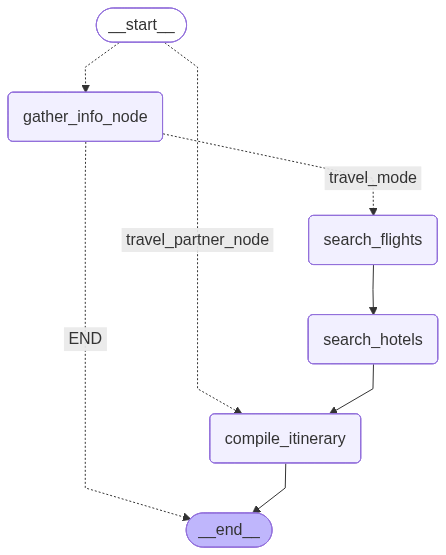

In [9]:
from IPython.display import Image, display

display(Image(builder.get_graph().draw_mermaid_png()))

In [10]:
ans = builder.invoke({
        "messages": [
            {
                "role": "user",
                "content": "I want to go to bangkok from taiyuan for 2 days",
            }
        ],
        "TravelMode": "Travel_Plan"
    },
    config = {"configurable":{"thread_id": thread_id}}
)
print(ans)

print("\n\n\nChatBot:   ", ans['messages'][-1].content)

--- Gathering Info Node ---
Missing before this turn: ['Departure', 'Destination', 'StartDate', 'Duration', 'Budget', 'Interest', 'ExtraDetail']
ss: None
{'messages': [HumanMessage(content='I want to go to bangkok from taiyuan for 2 days', additional_kwargs={}, response_metadata={}, id='a08552de-87d9-4254-a384-97fe07503626'), AIMessage(content='Great! To help me plan your trip to Bangkok, could you please tell me your desired start date, your budget, and what kind of interests you have for this trip?', additional_kwargs={}, response_metadata={}, id='e4eab7fb-2759-40b4-9017-1016c25916f6', tool_calls=[], invalid_tool_calls=[])], 'Departure': 'Taiyuan', 'Destination': ['Bangkok'], 'StartDate': None, 'Duration': '2 days', 'Budget': None, 'Interest': None, 'AllDetails': False, 'ExtraDetail': None, 'TravelMode': 'Travel_Plan'}



ChatBot:    Great! To help me plan your trip to Bangkok, could you please tell me your desired start date, your budget, and what kind of interests you have for this

In [11]:
ans = builder.invoke({
        "messages": [
            {
                "role": "user",
                "content": "I'm going next month same date as of today",
            }
        ],
        "TravelMode": "Travel_Plan"
    },
    config = {"configurable":{"thread_id": thread_id}}
)
print(ans)

print("\n\n\nChatBot:   ", ans['messages'][-1].content)

--- Gathering Info Node ---
Missing before this turn: ['StartDate', 'Budget', 'Interest', 'ExtraDetail']
ss: None
{'messages': [HumanMessage(content='I want to go to bangkok from taiyuan for 2 days', additional_kwargs={}, response_metadata={}, id='a08552de-87d9-4254-a384-97fe07503626'), AIMessage(content='Great! To help me plan your trip to Bangkok, could you please tell me your desired start date, your budget, and what kind of interests you have for this trip?', additional_kwargs={}, response_metadata={}, id='e4eab7fb-2759-40b4-9017-1016c25916f6', tool_calls=[], invalid_tool_calls=[]), HumanMessage(content="I'm going next month same date as of today", additional_kwargs={}, response_metadata={}, id='7bb6c6a5-c706-407f-afa7-cb13624fa768'), AIMessage(content="Great! So your trip will start on 2026-02-16. To help me plan your perfect trip, could you please tell me about your budget, interests, and any extra details you'd like to share?", additional_kwargs={}, response_metadata={}, id='3d9

In [12]:
ans = builder.invoke({
        "messages": [
            {
                "role": "user",
                "content": "I want Halal Food and 5 star hotel stay",
            }
        ],
        "TravelMode": "Travel_Plan"
    },
    config = {"configurable":{"thread_id": thread_id}}
)
print(ans)

print("\n\n\nChatBot:   ", ans['messages'][-1].content)

--- Gathering Info Node ---
Missing before this turn: ['Budget', 'Interest', 'ExtraDetail']
ss: None
{'messages': [HumanMessage(content='I want to go to bangkok from taiyuan for 2 days', additional_kwargs={}, response_metadata={}, id='a08552de-87d9-4254-a384-97fe07503626'), AIMessage(content='Great! To help me plan your trip to Bangkok, could you please tell me your desired start date, your budget, and what kind of interests you have for this trip?', additional_kwargs={}, response_metadata={}, id='e4eab7fb-2759-40b4-9017-1016c25916f6', tool_calls=[], invalid_tool_calls=[]), HumanMessage(content="I'm going next month same date as of today", additional_kwargs={}, response_metadata={}, id='7bb6c6a5-c706-407f-afa7-cb13624fa768'), AIMessage(content="Great! So your trip will start on 2026-02-16. To help me plan your perfect trip, could you please tell me about your budget, interests, and any extra details you'd like to share?", additional_kwargs={}, response_metadata={}, id='3d9c598e-43d7-42

In [13]:
ans = builder.invoke({
        "messages": [
            {
                "role": "user",
                "content": "budget is 2000 and interest are clubbing",
            }
        ],
        "TravelMode": "Travel_Plan"
    },
    config = {"configurable":{"thread_id": thread_id}}
)
print(ans)

print("\n\n\nChatBot:   ", ans['messages'][-1].content)

--- Gathering Info Node ---
Missing before this turn: ['Budget']
ss: None
--- Flight Node (Running) for Bangkok ---
Flight Info Captured.
--- Hotel, Restaurant and Attraction Node (Running) ---
Accommodation Info Captured.
Flight Node Info: [{'type': 'text', 'text': "The lowest available price for a one-way flight from Taiyuan to Bangkok on 2026-02-16 is $239. The current price status is high.\n\n**Best Flight Options:**\n*   **Flight Option 1:** Price: $239, Total Flight Duration: 9.4 hours, Layover: Shenzhen Bao'an International Airport\n*   **Flight Option 2:** Price: $266, Total Flight Duration: 14.7 hours, Layover: Xiamen Gaoqi International Airport\n*   **Flight Option 3:** Price: $272, Total Flight Duration: 11.4 hours, Layover: Shenzhen Bao'an International Airport\n*   **Flight Option 4:** Price: $272, Total Flight Duration: 15.2 hours, Layover: Shenzhen Bao'an International Airport\n\n**Other Options:**\n*   **Flight Option 1:** Price: $556, Total Flight Duration: 11.9 hours,